In [1]:
import os
os.environ["PIP_CACHE_DIR"] = "/workspace/.cache/pip"
os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from joblib import load
from tqdm import tqdm

# Probe Visualization on AquaRAT

This notebook:
1. Loads pre-trained error/lie probes from `error_vs_lie_detectors/`
2. Loads AquaRAT dataset
3. Generates a rollout with hidden state capture
4. Plots probe predictions over token index for multiple layers

In [3]:
# Load model and tokenizer
MODEL = "Qwen/Qwen3-0.6B"
tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
model.eval()
print(f"Model loaded: {MODEL}")
print(f"Device: {next(model.parameters()).device}")
print(f"Num layers: {model.config.num_hidden_layers}")

`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded: Qwen/Qwen3-0.6B
Device: cuda:0
Num layers: 28


In [4]:
# Load probes for selected layers (14, 17, 20, 23)
# Note: layer directories are 1-indexed (layer14 = index 13)
LAYER_INDICES = [13, 16, 19, 22]  # 0-indexed
LAYER_NAMES = [14, 17, 20, 23]    # 1-indexed for display

probes = {}
for layer_idx, layer_name in zip(LAYER_INDICES, LAYER_NAMES):
    layer_dir = f'error_vs_lie_detectors/layer{layer_name}'
    probes[layer_idx] = {
        'lie_vs_error': load(f'{layer_dir}/lie_vs_error.joblib'),
        'error_vs_truth': load(f'{layer_dir}/error_vs_truth.joblib'),
        'lie_vs_truth': load(f'{layer_dir}/lie_vs_truth.joblib'),
    }
    print(f"Loaded probes for layer {layer_name}")

Loaded probes for layer 14
Loaded probes for layer 17
Loaded probes for layer 20
Loaded probes for layer 23


In [5]:
# Load AquaRAT dataset
ds = load_dataset("deepmind/aqua_rat", split="test")
print(f"Loaded {len(ds)} problems from AquaRAT")

# Pick first problem
problem = ds[0]
print(f"\nProblem:")
print(f"Question: {problem['question']}")
print(f"Options: {problem['options']}")
print(f"Correct: {problem['correct']}")

README.md: 0.00B [00:00, ?B/s]

raw/train-00000-of-00001.parquet:   0%|          | 0.00/25.4M [00:00<?, ?B/s]

raw/test-00000-of-00001.parquet:   0%|          | 0.00/74.0k [00:00<?, ?B/s]

raw/validation-00000-of-00001.parquet:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/97467 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/254 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/254 [00:00<?, ? examples/s]

Loaded 254 problems from AquaRAT

Problem:
Question: A car is being driven, in a straight line and at a uniform speed, towards the base of a vertical tower. The top of the tower is observed from the car and, in the process, it takes 10 minutes for the angle of elevation to change from 45° to 60°. After how much more time will this car reach the base of the tower?
Options: ['A)5(√3 + 1)', 'B)6(√3 + √2)', 'C)7(√3 – 1)', 'D)8(√3 – 2)', 'E)None of these']
Correct: A


In [6]:
# Prompt building (adapted from generate_rollouts.ipynb)
SYSTEM = (
    "Solve the math question. "
    "Think step by step. "
    "At the end, output exactly one line: Answer: X "
    "where X is the letter of the correct option (A, B, C, D, or E)."
)

def make_user(q, options):
    """Create user message with question and options."""
    opts_str = "\n".join(options)
    return f"Question:\n{q}\n\nOptions:\n{opts_str}\n"

def build_chat_input(tokenizer, q, options, enable_thinking=True):
    """Build chat input for AquaRAT."""
    messages = [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": make_user(q, options)},
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
    )
    return text

In [7]:
@torch.inference_mode()
def generate_with_hidden_states(question, options, max_new_tokens=400):
    """Generate response and capture hidden states for each token.
    
    Returns:
        gen_text: Generated text
        hidden_states: dict[layer_idx] -> np.array of shape (num_tokens, hidden_dim)
    """
    prompt = build_chat_input(tok, question, options, enable_thinking=True)
    inputs = tok([prompt], return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]
    
    # Generate with hidden states
    outputs = model.generate(
        **inputs,
        do_sample=True,
        temperature=0.6,
        top_p=0.95,
        top_k=20,
        max_new_tokens=max_new_tokens,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.pad_token_id,
        output_hidden_states=True,
        return_dict_in_generate=True,
    )
    
    # Decode generated text
    gen_ids = outputs.sequences[0][input_len:]
    gen_text = tok.decode(gen_ids, skip_special_tokens=False)
    
    # Extract hidden states for each generated token
    # outputs.hidden_states is a tuple of length num_generated_tokens
    # Each element is a tuple of (num_layers+1) tensors of shape (batch, seq_len, hidden_dim)
    # We want the last token position from each step (the newly generated token)
    
    num_gen_tokens = len(outputs.hidden_states)
    num_layers = len(outputs.hidden_states[0]) - 1  # -1 for embedding layer
    hidden_dim = outputs.hidden_states[0][0].shape[-1]
    
    print(f"Generated {num_gen_tokens} tokens")
    print(f"Model has {num_layers} layers, hidden_dim={hidden_dim}")
    
    # Collect hidden states per layer
    hidden_states = {}
    for layer_idx in LAYER_INDICES:
        layer_hs = []
        for step_idx in range(num_gen_tokens):
            # hidden_states[step][layer] has shape (batch, seq_len, hidden_dim)
            # Take the last position (the new token being generated)
            hs = outputs.hidden_states[step_idx][layer_idx + 1]  # +1 to skip embedding
            hs_last = hs[0, -1, :].cpu().float().numpy()  # (hidden_dim,)
            layer_hs.append(hs_last)
        hidden_states[layer_idx] = np.stack(layer_hs, axis=0)  # (num_tokens, hidden_dim)
    
    return gen_text, hidden_states, gen_ids.tolist()

In [8]:
# Generate rollout on the problem
gen_text, hidden_states, gen_ids = generate_with_hidden_states(
    problem['question'],
    problem['options'],
    max_new_tokens=1000
)

print(f"\n=== Generated Text ===")
print(gen_text)
# print(gen_text[:1000] + "..." if len(gen_text) > 1000 else gen_text)

Generated 1000 tokens
Model has 28 layers, hidden_dim=1024

=== Generated Text ===
<think>
Okay, let's try to figure out this problem. So, there's a car moving towards a vertical tower at a uniform speed. The angle of elevation changes from 45 degrees to 60 degrees over 10 minutes. We need to find out how much more time it will take for the car to reach the base of the tower.

First, I remember that when dealing with angles of elevation and distances, trigonometry is involved. Since the car is moving horizontally and the tower is vertical, the triangle formed by the car, the base of the tower, and the top of the tower is a right triangle. The horizontal distance from the car to the base of the tower would be the adjacent side, and the height of the tower would be the opposite side.

The angles of elevation are given as 45° and 60°. Let me denote the height of the tower as h. Let me also denote the horizontal distance from the car to the base of the tower as d. 

When the car is at the 

In [9]:
# Apply probes to hidden states and get predictions
probe_predictions = {}

for layer_idx in LAYER_INDICES:
    layer_name = layer_idx + 1  # 1-indexed for display
    hs = hidden_states[layer_idx]  # (num_tokens, hidden_dim)
    
    probe_predictions[layer_idx] = {}
    
    for probe_name, probe in probes[layer_idx].items():
        # predict_proba returns (num_samples, 2) for binary classification
        probs = probe.predict_proba(hs)  # (num_tokens, 2)
        # Take probability of class 1
        probe_predictions[layer_idx][probe_name] = probs[:, 1]
    
    print(f"Layer {layer_name}: predictions computed for {len(hs)} tokens")

Layer 14: predictions computed for 1000 tokens
Layer 17: predictions computed for 1000 tokens
Layer 20: predictions computed for 1000 tokens
Layer 23: predictions computed for 1000 tokens


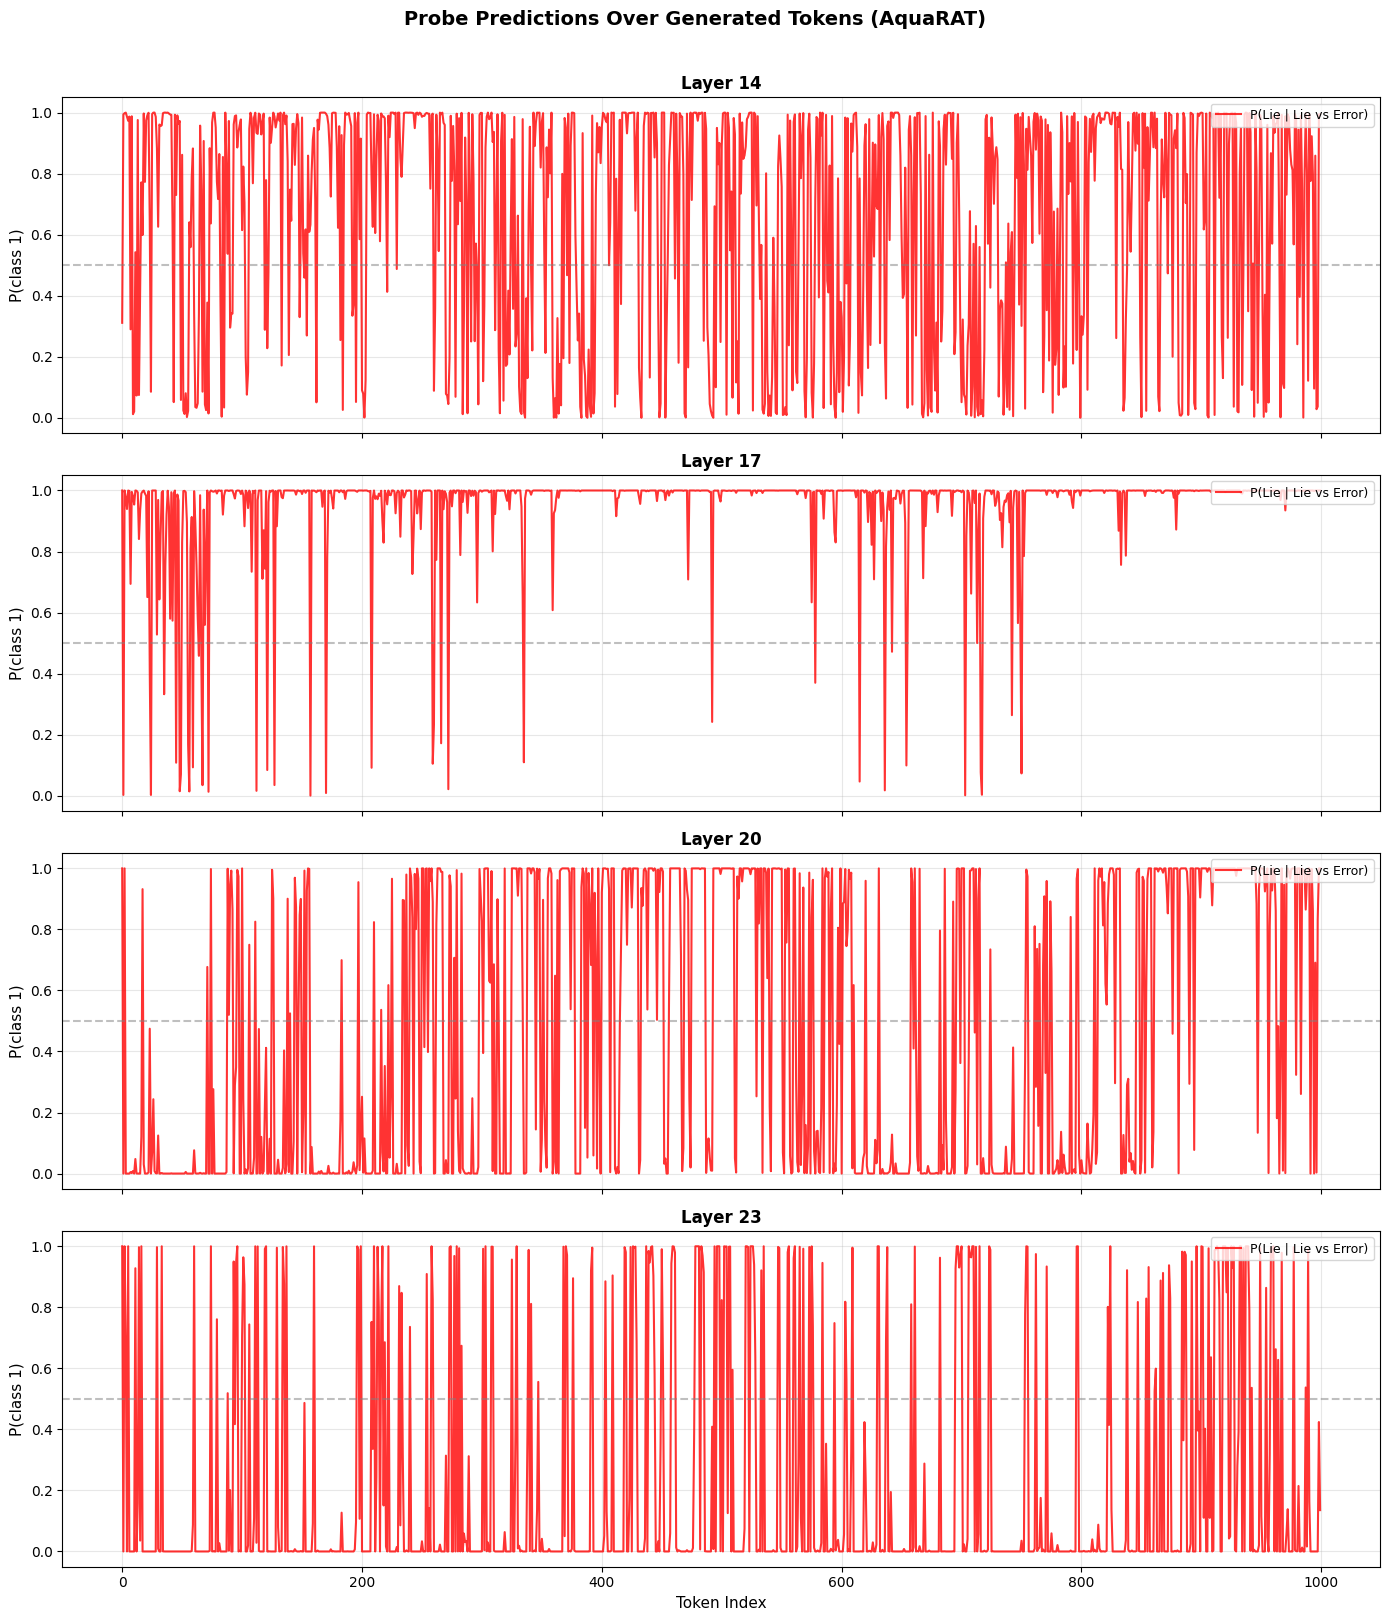


Saved plot to probe_visualization.png


In [15]:
# Plot probe predictions over token index
fig, axes = plt.subplots(len(LAYER_INDICES), 1, figsize=(14, 4 * len(LAYER_INDICES)), sharex=True)

# Get token strings for x-axis labels (show every Nth token)
token_strs = [tok.decode([t]) for t in gen_ids]
num_tokens = len(token_strs)

colors = {
    'lie_vs_error': 'red',
    'error_vs_truth': 'blue',
    'lie_vs_truth': 'green',
}

labels = {
    'lie_vs_error': 'P(Lie | Lie vs Error)',
    'error_vs_truth': 'P(Error | Error vs Truth)',
    'lie_vs_truth': 'P(Lie | Lie vs Truth)',
}

for ax_idx, layer_idx in enumerate(LAYER_INDICES):
    ax = axes[ax_idx]
    layer_name = layer_idx + 1
    
    for probe_name in ['lie_vs_error']:
        probs = probe_predictions[layer_idx][probe_name]
        ax.plot(range(num_tokens), probs, 
                color=colors[probe_name], 
                label=labels[probe_name],
                alpha=0.8, linewidth=1.5)
    
    ax.set_ylabel('P(class 1)', fontsize=11)
    ax.set_title(f'Layer {layer_name}', fontsize=12, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Token Index', fontsize=11)

plt.suptitle('Probe Predictions Over Generated Tokens (AquaRAT)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('probe_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved plot to probe_visualization.png")

In [14]:
# Show token-level detail for first 50 tokens
print("Token-level predictions (first 50 tokens):")
print("="*80)

layer_idx = LAYER_INDICES[0]  # Use first layer for display
layer_name = layer_idx + 1

print(f"\nLayer {layer_name}:")
print(f"{'Idx':>4} {'Token':>15} {'Lie/Err':>8} {'Err/Tr':>8} {'Lie/Tr':>8}")
print("-"*50)

for i in range(min(50, num_tokens)):
    token_str = token_strs[i].replace('\n', '\\n')[:12]
    le = probe_predictions[layer_idx]['lie_vs_error'][i]
    et = probe_predictions[layer_idx]['error_vs_truth'][i]
    lt = probe_predictions[layer_idx]['lie_vs_truth'][i]
    print(f"{i:>4} {token_str:>15} {le:>8.3f} {et:>8.3f} {lt:>8.3f}")

Token-level predictions (first 50 tokens):

Layer 14:
 Idx           Token  Lie/Err   Err/Tr   Lie/Tr
--------------------------------------------------
   0         <think>    0.311    0.276    0.167
   1              \n    0.994    1.000    0.967
   2            Okay    0.998    0.345    0.996
   3               ,    1.000    1.000    1.000
   4             let    0.986    0.312    0.952
   5              's    0.973    0.988    0.966
   6             try    0.987    1.000    0.987
   7              to    0.290    1.000    0.472
   8          figure    0.988    0.987    0.990
   9             out    0.012    0.977    0.008
  10            this    0.020    0.502    0.006
  11         problem    0.542    0.300    0.301
  12               .    0.073    0.768    0.037
  13              So    0.976    0.690    0.975
  14               ,    0.075    1.000    0.230
  15           there    0.432    0.015    0.292
  16              's    0.771    0.000    0.569
  17               a    0.599  

In [19]:
from IPython.display import HTML, display
import html

def prob_to_color(prob, low_color=(0, 100, 255), high_color=(255, 50, 50)):
    """Interpolate between blue (0) and red (1).
    
    Args:
        prob: float in [0, 1]
        low_color: RGB tuple for prob=0 (blue)
        high_color: RGB tuple for prob=1 (red)
    
    Returns:
        RGB tuple
    """
    r = int(low_color[0] + (high_color[0] - low_color[0]) * prob)
    g = int(low_color[1] + (high_color[1] - low_color[1]) * prob)
    b = int(low_color[2] + (high_color[2] - low_color[2]) * prob)
    return (r, g, b)

def get_text_color(bg_rgb):
    """Return black or white text color based on background brightness."""
    # Calculate perceived brightness
    brightness = (bg_rgb[0] * 299 + bg_rgb[1] * 587 + bg_rgb[2] * 114) / 1000
    return "black" if brightness > 128 else "white"

def render_text_heatmap(token_strs, probs, title="Text Heatmap", max_width=120):
    """Render tokens with background colors based on probe probabilities.
    
    Args:
        token_strs: list of token strings
        probs: array of probabilities [0, 1] for each token
        title: title for the visualization
        max_width: approximate max characters per line before wrapping
    """
    html_parts = [
        f'<div style="font-family: monospace; font-size: 14px; line-height: 1.8; padding: 10px; background: #1a1a1a; border-radius: 8px;">',
        f'<div style="color: #ccc; margin-bottom: 10px; font-weight: bold;">{title}</div>',
        '<div style="word-wrap: break-word;">'
    ]
    
    current_line_len = 0
    
    for i, (token, prob) in enumerate(zip(token_strs, probs)):
        bg_rgb = prob_to_color(prob)
        text_color = get_text_color(bg_rgb)
        
        # Escape HTML and handle special characters
        display_token = html.escape(token)
        display_token = display_token.replace('\n', '<br>')
        display_token = display_token.replace(' ', '&nbsp;')
        
        # Handle empty tokens
        if display_token == '':
            display_token = '·'
        
        span = (
            f'<span style="background-color: rgb({bg_rgb[0]},{bg_rgb[1]},{bg_rgb[2]}); '
            f'color: {text_color}; padding: 2px 1px; border-radius: 2px; '
            f'margin: 1px;" title="idx={i}, p={prob:.3f}">{display_token}</span>'
        )
        html_parts.append(span)
        
        # Track line length for approximate wrapping hint
        current_line_len += len(token)
        if '\n' in token:
            current_line_len = 0
    
    html_parts.append('</div></div>')
    
    # Add color legend
    legend = '''
    <div style="font-family: monospace; font-size: 12px; margin-top: 10px; padding: 5px; background: #2a2a2a; border-radius: 4px; display: inline-block;">
        <span style="color: #ccc;">Legend: </span>
        <span style="background: rgb(0,100,255); color: white; padding: 2px 8px; border-radius: 2px;">0.0</span>
        <span style="color: #666;"> ← P(class 1) → </span>
        <span style="background: rgb(255,50,50); color: white; padding: 2px 8px; border-radius: 2px;">1.0</span>
    </div>
    '''
    html_parts.append(legend)
    
    return HTML(''.join(html_parts))

def show_text_heatmap(layer_idx=13, probe_name='lie_vs_error'):
    """Display text heatmap for a given layer and probe.
    
    Args:
        layer_idx: 0-indexed layer (13, 16, 19, 22)
        probe_name: 'lie_vs_error', 'error_vs_truth', or 'lie_vs_truth'
    """
    layer_name = layer_idx + 1
    probs = [round(x) for x in probe_predictions[layer_idx][probe_name]]
    
    probe_labels = {
        'lie_vs_error': 'P(Lie) - Lie vs Error',
        'error_vs_truth': 'P(Error) - Error vs Truth',
        'lie_vs_truth': 'P(Lie) - Lie vs Truth',
    }
    
    title = f"Layer {layer_name} | {probe_labels[probe_name]}"
    return render_text_heatmap(token_strs, probs, title=title)

In [21]:
# Display text heatmap (default: lie_vs_error, layer 14)
# Red = P(Lie) = 1.0, Blue = P(Error) = 0.0
display(show_text_heatmap(layer_idx=13, probe_name='lie_vs_error'))

In [ ]:
# Try other layers or probes by uncommenting:
# display(show_text_heatmap(layer_idx=16, probe_name='lie_vs_error'))  # Layer 17
# display(show_text_heatmap(layer_idx=19, probe_name='lie_vs_error'))  # Layer 20
# display(show_text_heatmap(layer_idx=22, probe_name='lie_vs_error'))  # Layer 23

# Or try other probes:
# display(show_text_heatmap(layer_idx=13, probe_name='error_vs_truth'))
# display(show_text_heatmap(layer_idx=13, probe_name='lie_vs_truth'))